In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
#setting up your device: enable gpu at kaggle environment to get better perfomance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

In [ ]:
data_dir = '/content/drive/My Drive/5424/hair_loss.csv'
data_df = pd.read_csv(data_dir)
print(data_df.head(2))

   total_protein  total_keratine  hair_texture  vitamin  manganese  iron  \
0            312             100            14      249         87    55   
1             52             207             3      425        387     1   

   calcium  body_water_content  stress_level  liver_data  hair_fall  
0      333                  44            41         368          4  
1      182                  26            65          41          1  


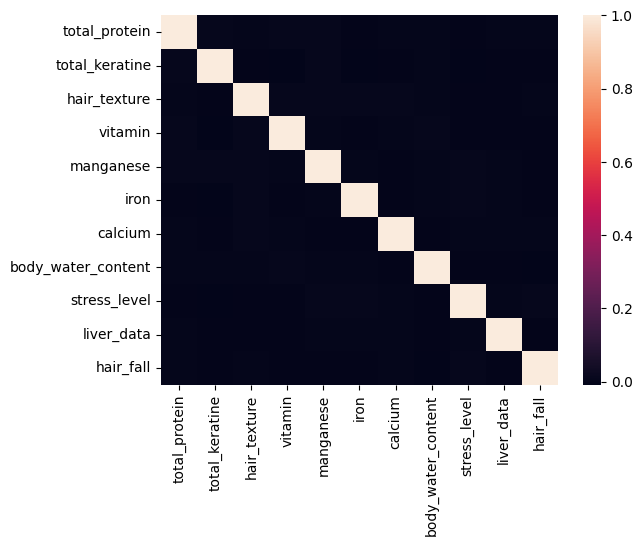

In [ ]:
#correlation between variables
sns.heatmap(data_df.corr())
plt.show()
data_df = data_df / data_df.max()
X_df, y_df = data_df.drop(columns='hair_fall'), data_df[['hair_fall']]

In [ ]:
X = torch.from_numpy(np.array(X_df)).type(torch.float)
y = torch.from_numpy(np.array(y_df)).squeeze().type(torch.float) #squeeze -> transform dimensions from [number_samples,1] to [number_samples]

X.shape, y.shape  #without squeeze, y would be torch.Size([100000,1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class NeuralNet(nn.Module):  #inherits from nn.Module (torch)
    def __init__(self,
                 in_features: int,   #number of input features (in our case, 13)
                 out_features: int,  #number of classes that we will predict (in our case, 6 music genres)
                 hidden_units: int,  #number of neurons in the hidden layers
                 n_hidden_layers: int):  #number of hidden layers (with hidden_units neurons)

        super().__init__()
        self.first_layer = nn.Linear(in_features=in_features, out_features=hidden_units)
        self.hidden_layer = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.last_layer = nn.Linear(in_features=hidden_units, out_features=out_features)
        self.relu = nn.ReLU()
        self.n_hidden_layers = n_hidden_layers

    def forward(self,x):
        z = self.relu(self.first_layer(x))

        for hidden_layer in range(self.n_hidden_layers):
            z = self.relu(self.hidden_layer(z))

        return self.last_layer(z)

In [ ]:
baseline_model = NeuralNet(in_features=10,
                          out_features=1,
                          hidden_units=8,
                          n_hidden_layers=2).to(device)
output_test = baseline_model(X_train.to(device))
output_test.shape   #our output has the right shape! probably everything is right in our model

torch.Size([80000, 1])

In [ ]:
def train_model(epochs, model, loss_fn, optimizer, train_dataloader, test_dataloader, show=True):
    model.to(device)
    ltrain_loss = []
    ltest_loss = []

    for epoch in range(epochs):
        ### Training
        model.train()
        train_epoch_loss = 0.0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.squeeze(-1)

            # 1. Forward Pass
            y_logits = model(X_batch)

            # Ajustar as dimensões para evitar broadcasting
            y_logits = y_logits.squeeze(-1)

            # 2. Calculate loss
            loss = loss_fn(y_logits, y_batch)

            # 3. Optimizer Zero Grad
            optimizer.zero_grad()

            # 4. Loss backwards
            loss.backward()

            # 5. Step optimizer
            optimizer.step()

            train_epoch_loss += loss.item()

        # Calculate average training loss for the epoch
        average_train_loss = train_epoch_loss / len(train_dataloader)

        ### Testing
        model.eval()
        test_epoch_loss = 0.0

        with torch.inference_mode():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.squeeze(-1)

                # 1. Forward Pass
                test_logits = model(X_batch)
                test_logits = test_logits.squeeze(-1)

                # 2. Calculate loss
                test_loss = loss_fn(test_logits, y_batch)

                test_epoch_loss += test_loss.item()

        # Calculate average testing loss for the epoch
        average_test_loss = test_epoch_loss / len(test_dataloader)

        if (epoch % 10 == 0) and show:
            print(f"Epoch: {epoch} | Train Loss: {average_train_loss:.5f}, Test Loss: {average_test_loss:.5f}")

        ltrain_loss.append(average_train_loss)
        ltest_loss.append(average_test_loss)

    return ltrain_loss, ltest_loss

In [ ]:
#setting optimizer and loss function
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.1)
#torch.save(model.state_dict(), 'best_net.pth') #saving a model
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
epochs= 500
ltrain_loss, ltest_loss = train_model(epochs, baseline_model, loss_fn, optimizer,train_dataloader, test_dataloader)

Epoch: 0 | Train Loss: 0.30030, Test Loss: 0.30235
Epoch: 10 | Train Loss: 0.30014, Test Loss: 0.30397
Epoch: 20 | Train Loss: 0.30044, Test Loss: 0.30158
Epoch: 30 | Train Loss: 0.30026, Test Loss: 0.30231
Epoch: 40 | Train Loss: 0.30028, Test Loss: 0.30271
Epoch: 50 | Train Loss: 0.30052, Test Loss: 0.30177
Epoch: 60 | Train Loss: 0.30048, Test Loss: 0.30191
Epoch: 70 | Train Loss: 0.30025, Test Loss: 0.30095
Epoch: 80 | Train Loss: 0.30029, Test Loss: 0.30232
Epoch: 90 | Train Loss: 0.30016, Test Loss: 0.30233
Epoch: 100 | Train Loss: 0.30017, Test Loss: 0.30327
Epoch: 110 | Train Loss: 0.30019, Test Loss: 0.30269
Epoch: 120 | Train Loss: 0.29995, Test Loss: 0.30167
Epoch: 130 | Train Loss: 0.29985, Test Loss: 0.30226
Epoch: 140 | Train Loss: 0.30006, Test Loss: 0.30175
Epoch: 150 | Train Loss: 0.29983, Test Loss: 0.30213
Epoch: 160 | Train Loss: 0.29977, Test Loss: 0.30314
Epoch: 170 | Train Loss: 0.29959, Test Loss: 0.30164
Epoch: 180 | Train Loss: 0.29975, Test Loss: 0.30174
Epoc

Final Train Loss: 0.2983, Final Test Loss: 0.3026


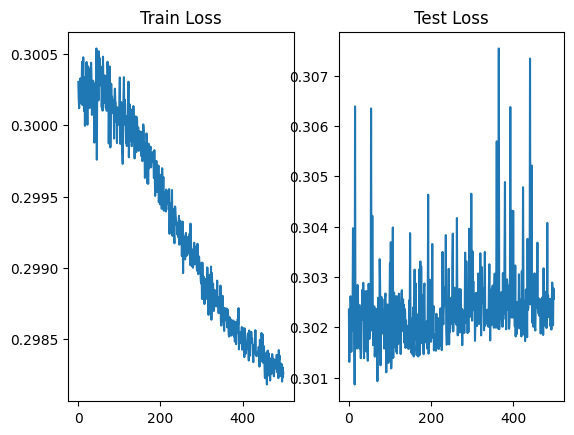

In [ ]:
print(f"Final Train Loss: {ltrain_loss[-1]:.4f}, Final Test Loss: {ltest_loss[-1]:.4f}")
fig, axes = plt.subplots(1,2)
axes[0].plot(ltrain_loss), axes[1].plot(ltest_loss)
axes[0].set_title("Train Loss"), axes[1].set_title("Test Loss")
plt.show()


In [ ]:
predictions = baseline_model(X_test).to(device)
predictions = predictions.squeeze()
for i, (pred, label) in enumerate(zip(predictions, y_test)):
    if i < 15:
        print(f"Sample: {i}, Prediction: {pred}, True Label: {label}")

Sample: 0, Prediction: 0.43052345514297485, True Label: 1.0
Sample: 1, Prediction: 0.5450298190116882, True Label: 0.20000000298023224
Sample: 2, Prediction: 0.4323018789291382, True Label: 0.6000000238418579
Sample: 3, Prediction: 0.43171226978302, True Label: 0.800000011920929
Sample: 4, Prediction: 0.4149357080459595, True Label: 0.6000000238418579
Sample: 5, Prediction: 0.5407894849777222, True Label: 0.4000000059604645
Sample: 6, Prediction: 0.4493493437767029, True Label: 1.0
Sample: 7, Prediction: 0.42871344089508057, True Label: 0.0
Sample: 8, Prediction: 0.41990694403648376, True Label: 0.800000011920929
Sample: 9, Prediction: 0.536978542804718, True Label: 0.4000000059604645
Sample: 10, Prediction: 0.5251431465148926, True Label: 0.800000011920929
Sample: 11, Prediction: 0.4081162214279175, True Label: 0.4000000059604645
Sample: 12, Prediction: 0.4377288818359375, True Label: 0.0
Sample: 13, Prediction: 0.42270028591156006, True Label: 1.0
Sample: 14, Prediction: 0.4218974411